In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
left_image_path = "C:/Users/dell/Desktop/CV/Pset5_Stereo and Motion/提供图像/view1m.png"
right_image_path = "C:/Users/dell/Desktop/CV/Pset5_Stereo and Motion/提供图像/view5m.png"

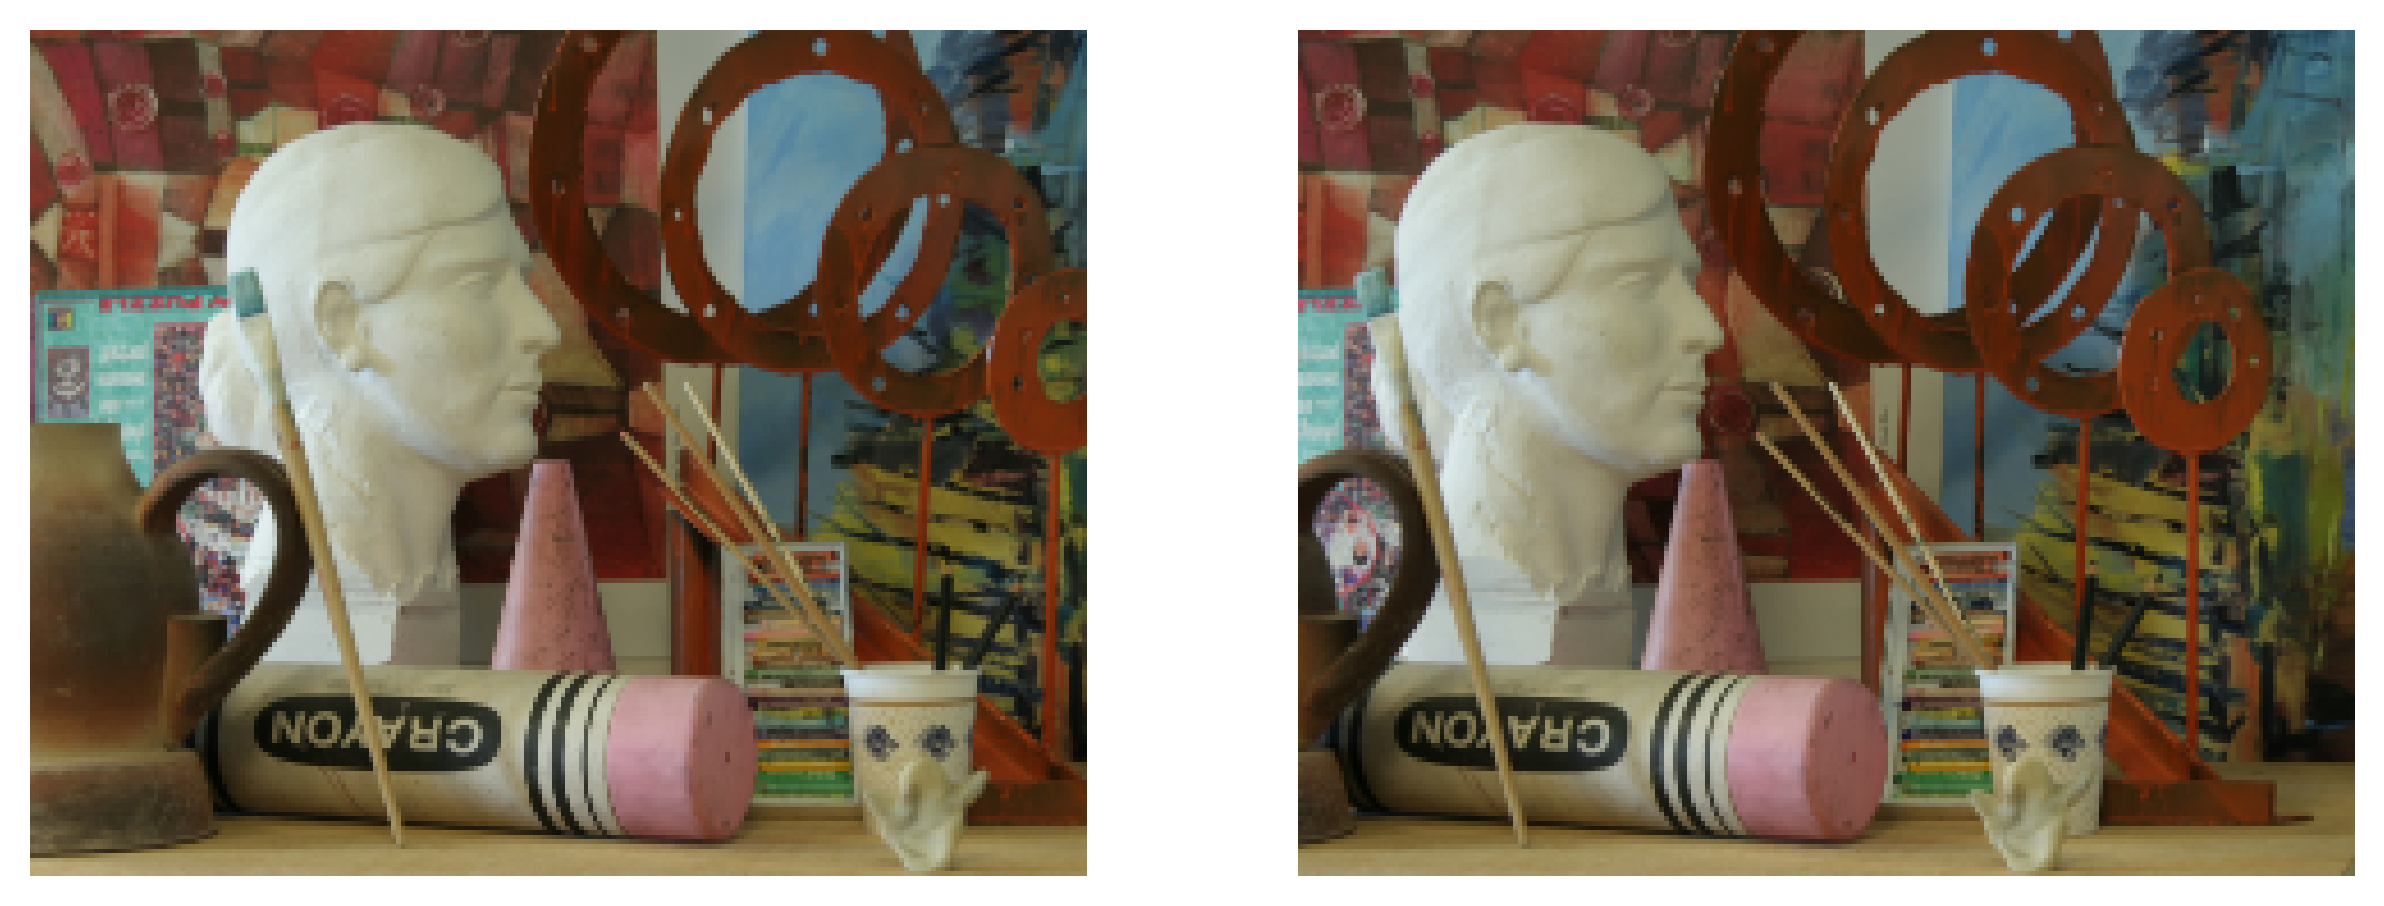

In [3]:
left_image = Image.open(left_image_path)
right_image = Image.open(right_image_path)
plt.figure(figsize=(10, 7), dpi=300)
plt.subplot(121)
plt.axis('off')
plt.imshow(left_image)
plt.subplot(122)
plt.axis('off')
plt.imshow(right_image)

In [4]:
L = np.asarray(left_image, dtype=np.float32)
R = np.asarray(right_image, dtype=np.float32)
image_shape = L.shape
image_shape

(185, 231, 3)

# Region Based Stereo Algorithms:

## Global Error Energy Minimization by Smoothing Functions

**Step 1. Calculate Energy**
$$
e(i, j, d) = \frac{1}{3\cdot n\cdot m} \cdot \sum_{x=i}^{i+n} \sum_{y=j}^{j+m} \sum_{k=1}^3 (L(x, y+d, k) - R(x, y, k))^2
$$

In [42]:
def cal_energy_at_pixel(e, L, R, i, j, d, n, m):
    sum = 0
    for x in range(i, i + n):
        for y in range(j, j + m):
            for k in range(3):
                sum += (L[x][y+d][k] - R[x][y][k]) ** 2
    e[i][j][d] = sum / (3 * n * m)

In [43]:
def cal_energy_at_disparity(e, L, R, d, n, m):
    I = e.shape[0]
    J = e.shape[1]
    for i in range(I):
        for j in range(J):
            cal_energy_at_pixel(e, L, R, i, j, d, n, m)

In [44]:
def cal_energy(e, L, R, n, m):
    d = e.shape[2]
    x = L.shape[0]
    y = L.shape[1]
    D = e.shape[2]
    L_with_padding = np.pad(L, ((0, n - 1),(0, m - 1 + D), (0, 0)), 'edge')
    R_with_padding = np.pad(R, ((0, n - 1),(0, m - 1 + D), (0, 0)), 'edge')
    for d_index in range(d):
        cal_energy_at_disparity(e, L_with_padding, R_with_padding, d_index, n, m)

In [45]:
D = 40
e = np.zeros((image_shape[0], image_shape[1], D))
cal_energy(e, L, R, 1, 1)

In [9]:
e_normalized = e / e.max()

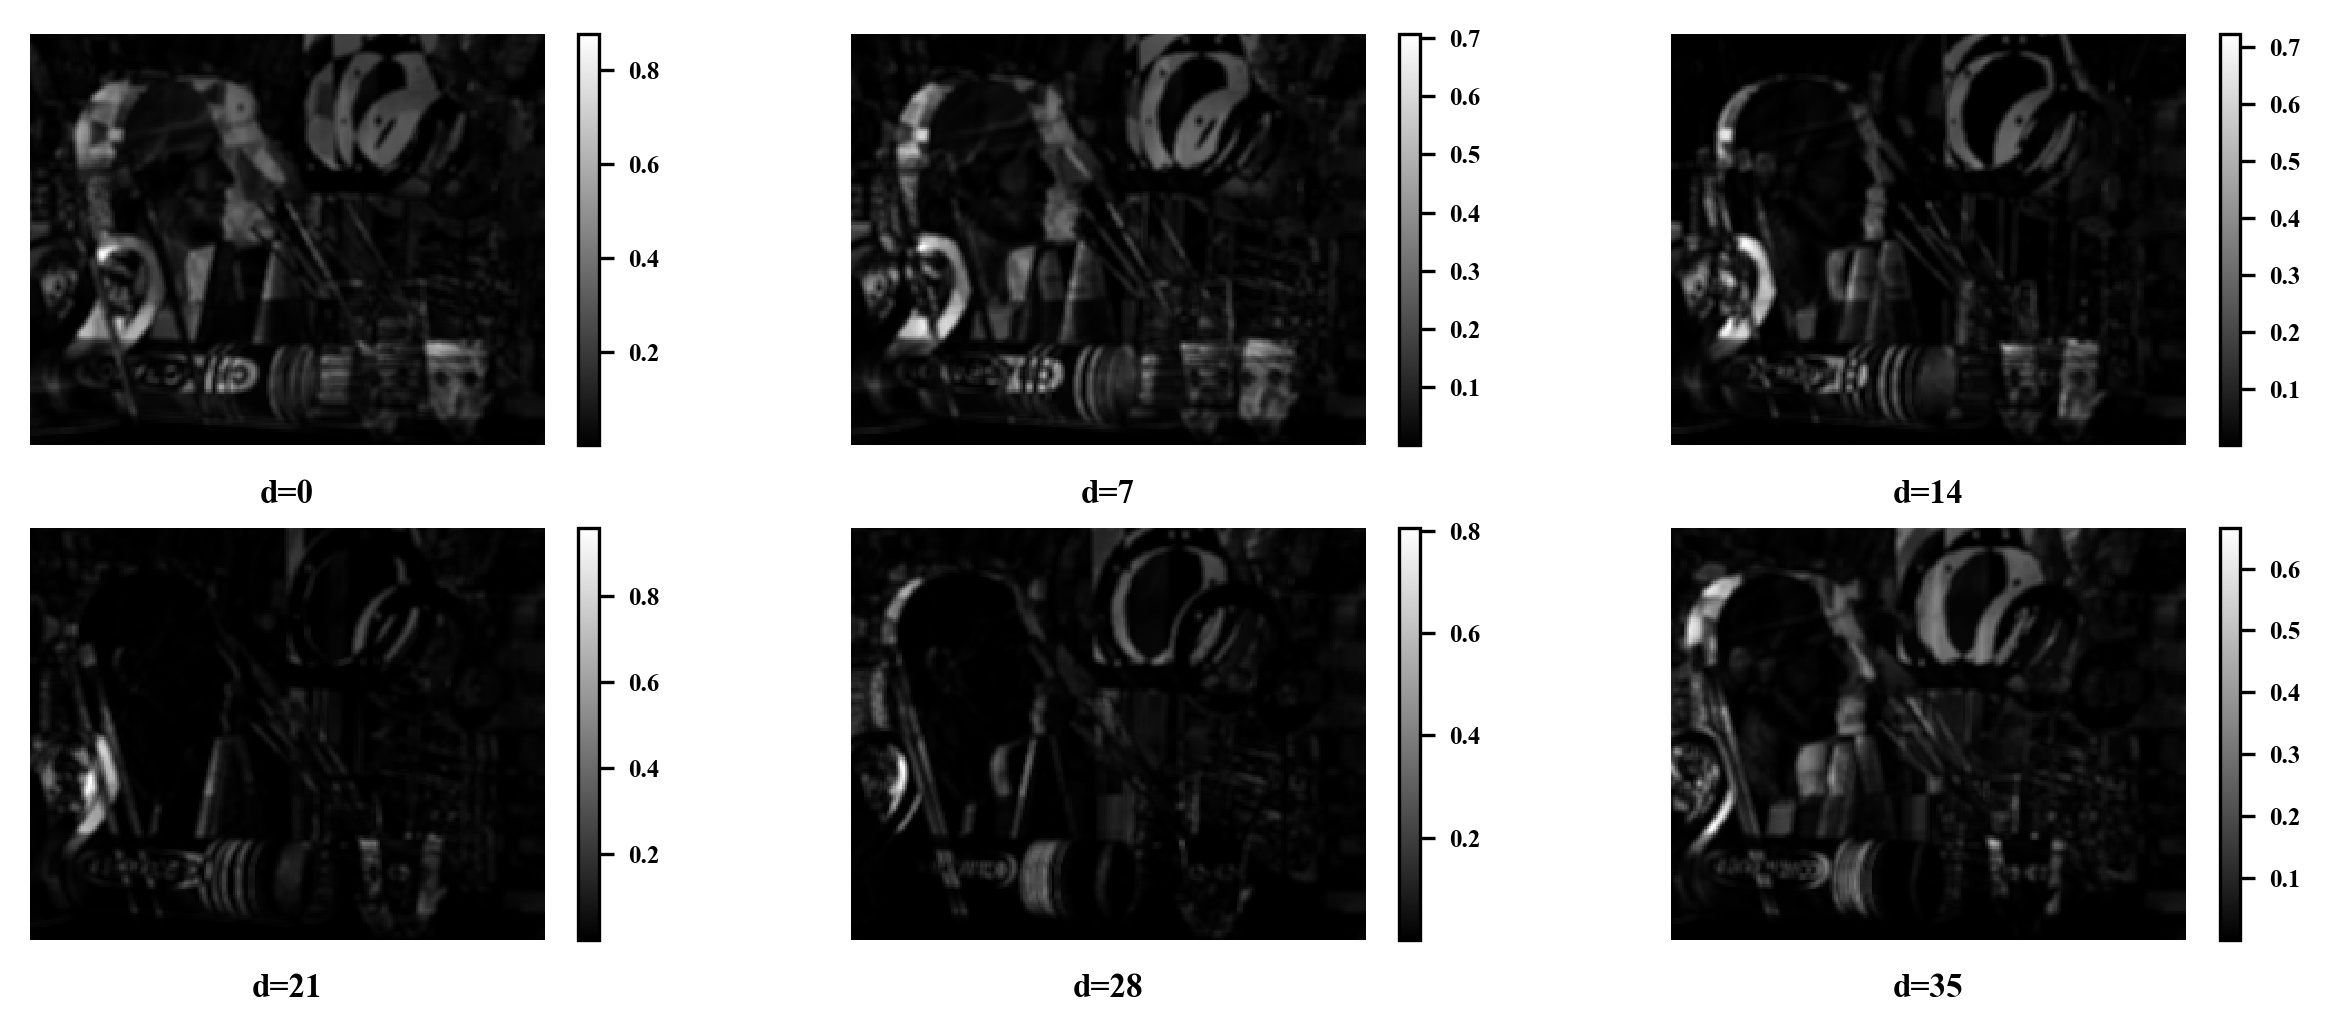

In [46]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(10, 4), dpi=300)

k = 7
for i in range(6): 
    plt.subplot('23' + str(i + 1))
    plt.axis('off')
    plt.title('d=%d' % (k * i), y=-0.2, fontsize=8)
    plt.imshow(e_normalized[:,:,k * i], cmap='gray')
    plt.colorbar()

#plt.savefig('./disparity_3x3.jpg', bbox_inches = 'tight')
#plt.savefig('./disparity_3x3.eps', dpi=300, format='eps', bbox_inches = 'tight')

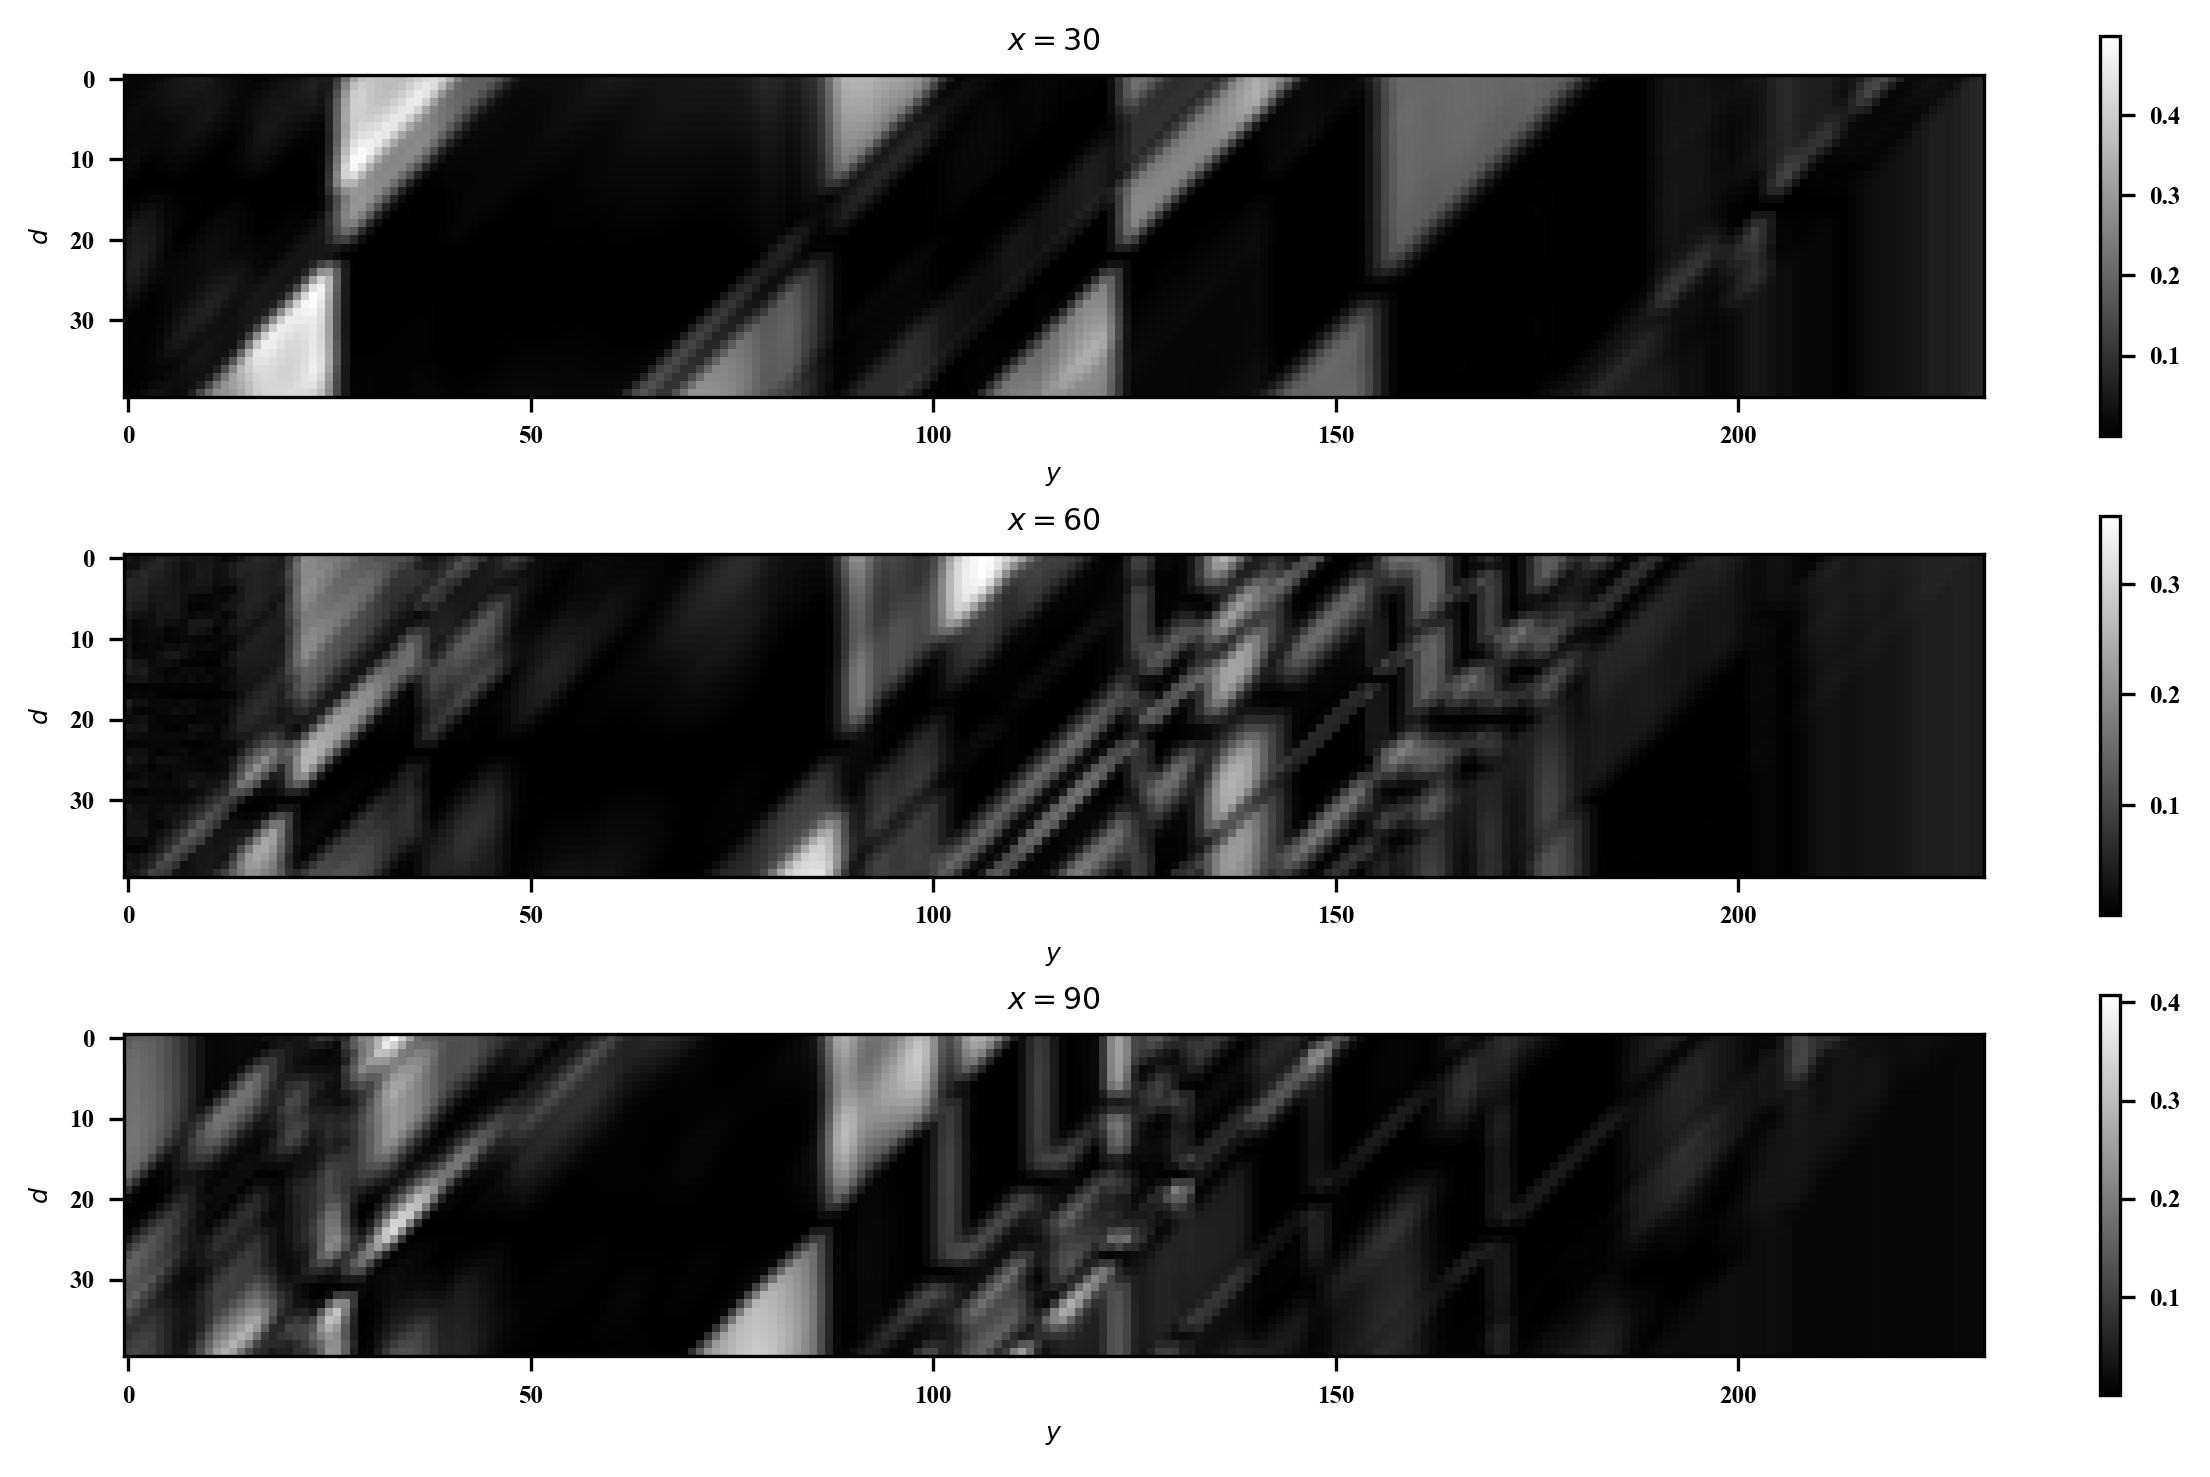

In [47]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(10, 6), dpi=300)
k = 30
for i in range(3):
    plt.subplot('31' + str(i + 1))
    plt.xlabel('$y$', fontsize=6)
    plt.ylabel('$d$', fontsize=6)
    plt.title('$x=%d$' % (k*(i + 1)))
    plt.imshow(e_normalized[k * (i + 1),:,0:40].T, cmap='gray')
    plt.colorbar()
#plt.savefig('./disparity_vs_y_1x1.jpg', bbox_inches = 'tight')
#plt.savefig('./disparity_vs_y.eps', dpi=300, format='eps', bbox_inches = 'tight')

**Step 2. Smoothing**
$$
\widetilde{e}(i,j,d) = \frac{1}{n \cdot m} \sum_{x=i}^{i+n} \sum_{y=j}^{j+m} e(x, y, d)
$$

In [48]:
def cal_mean(e, i, j, d, n, m):
    sum = 0
    for x in range(i, i + n):
        for y in range(j, j + m):
            sum += e[x][y][d]
    e[i][j][d] = sum / (n * m)

In [49]:
def smooth(e, n, m):
    I = e.shape[0]
    J = e.shape[1]
    d = e.shape[2]
    for i in range(I - n + 1):
        for j in range(J - m + 1):
            for d_index in range(d):
                cal_mean(e, i, j, d_index, n, m)

In [51]:
e_smoothed = e.copy()
smooth(e_smoothed, 1, 1)

**Step 3. Calculate D**
$$
D(i,j) = \arg \min_d {e(i, j, d)}
$$

In [52]:
D = np.zeros((image_shape[0], image_shape[1]))
D_smoothed = np.zeros((image_shape[0], image_shape[1]))

In [53]:
def argmin(e, i, j):
    d = e.shape[2]
    d_min = 0
    e_min = e[i][j][0]
    for d_index in range(d):
        if e_min > e[i][j][d_index]:
            d_min = d_index
            e_min = e[i][j][d_index]
    return d_min        

In [54]:
def cal_D(D, e):
    I = D.shape[0]
    J = D.shape[1]
    for i in range(I):
        for j in range(J):
            D[i][j] = argmin(e, i, j)

In [55]:
cal_D(D, e)
cal_D(D_smoothed, e_smoothed)

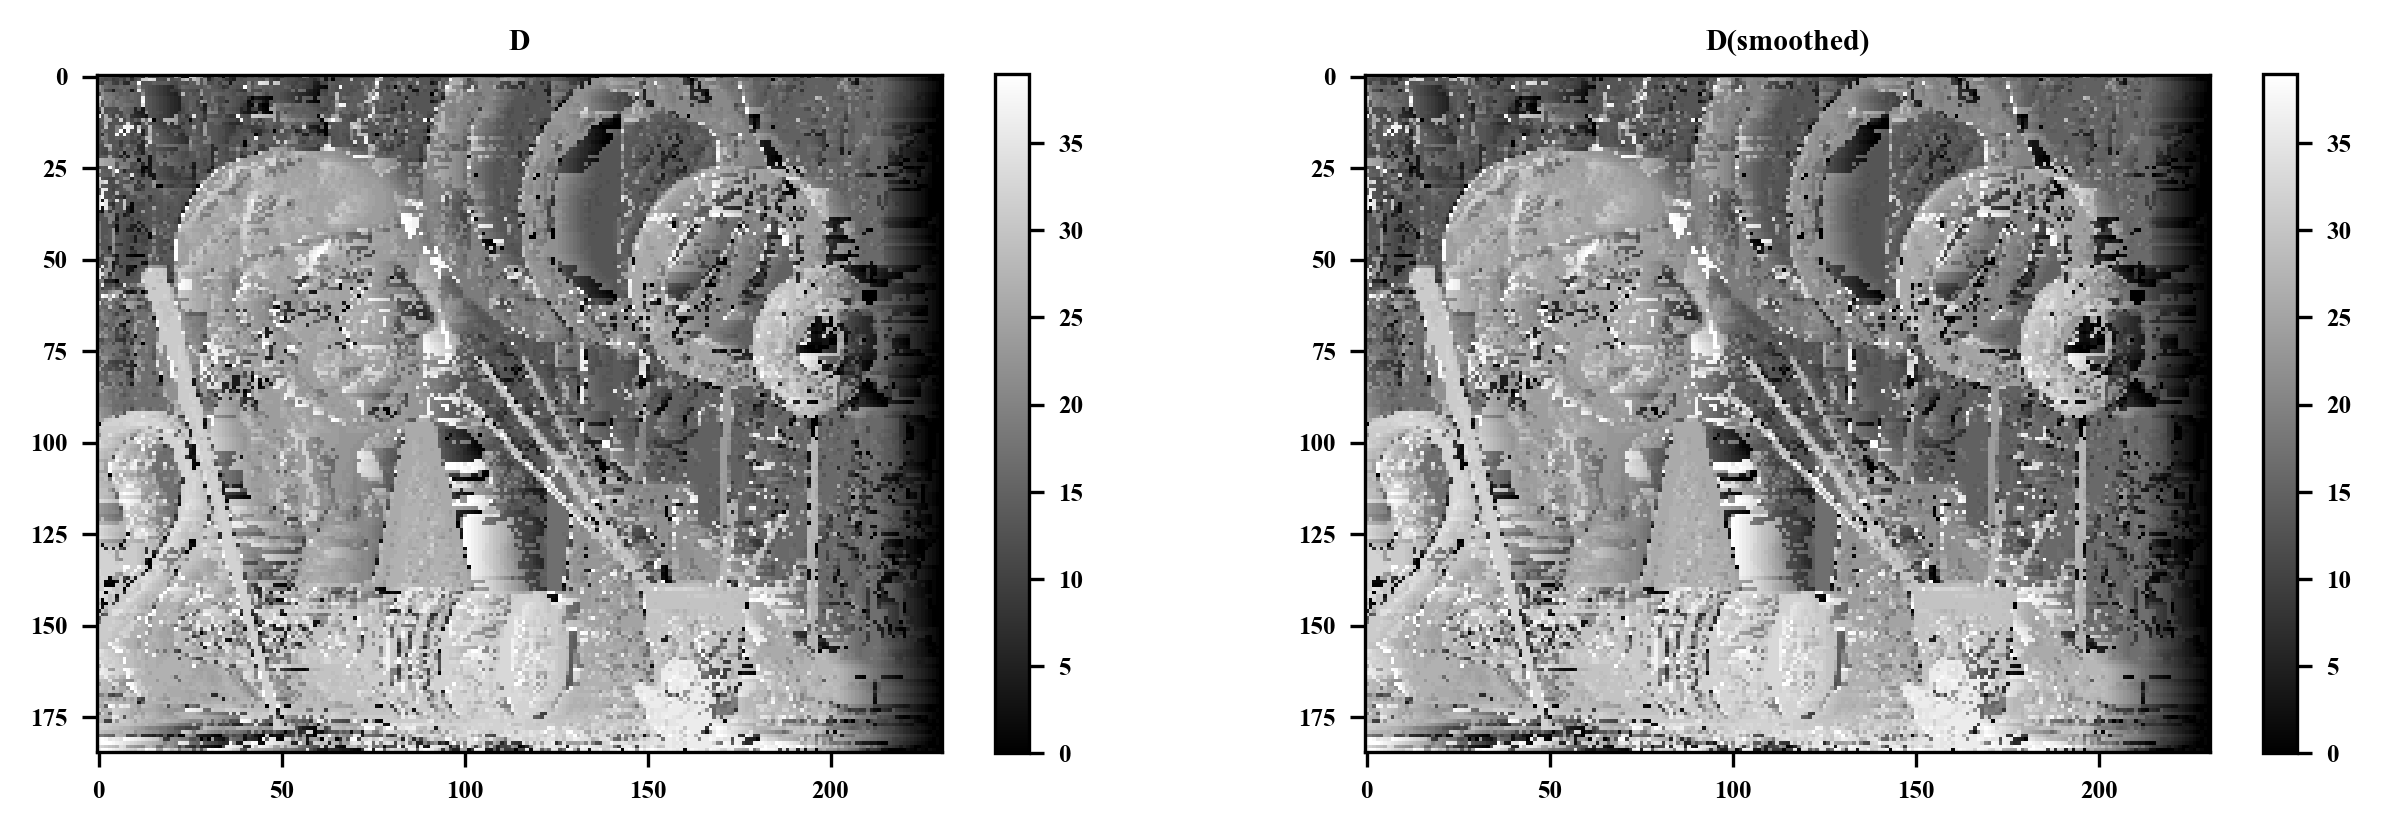

In [56]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(10, 3), dpi=300)
plt.subplot(121)
plt.title('D')
plt.imshow(D, cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.title('D(smoothed)')
plt.imshow(D_smoothed, cmap='gray')
plt.colorbar()
#plt.savefig('./D_1x1.jpg', bbox_inches = 'tight')

**Calculate $E_d$.**
$$
E_d(i, j) = \frac{1}{3 \cdot n \cdot m} \sum_{x=i}^{i+n} \sum_{y=j}^{j+m} \sum_{k=1}^3 (L(x, y+d(i,j), k) - R(x, y, k))^2
$$

$$
E_d(i,j) = e(i, j, d(i, j))
$$

In [21]:
def cal_E_d(E_d, e, d):
    I = E_d.shape[0]
    J = E_d.shape[1]
    for i in range(I):
        for j in range(J):
            E_d[i][j] = e[i][j][(int)(d[i][j])]

In [22]:
E_d = np.zeros((image_shape[0], image_shape[1]))
E_d_smoothed = np.zeros((image_shape[0], image_shape[1]))
cal_E_d(E_d, e, D)
cal_E_d(E_d_smoothed, e_smoothed, D_smoothed)

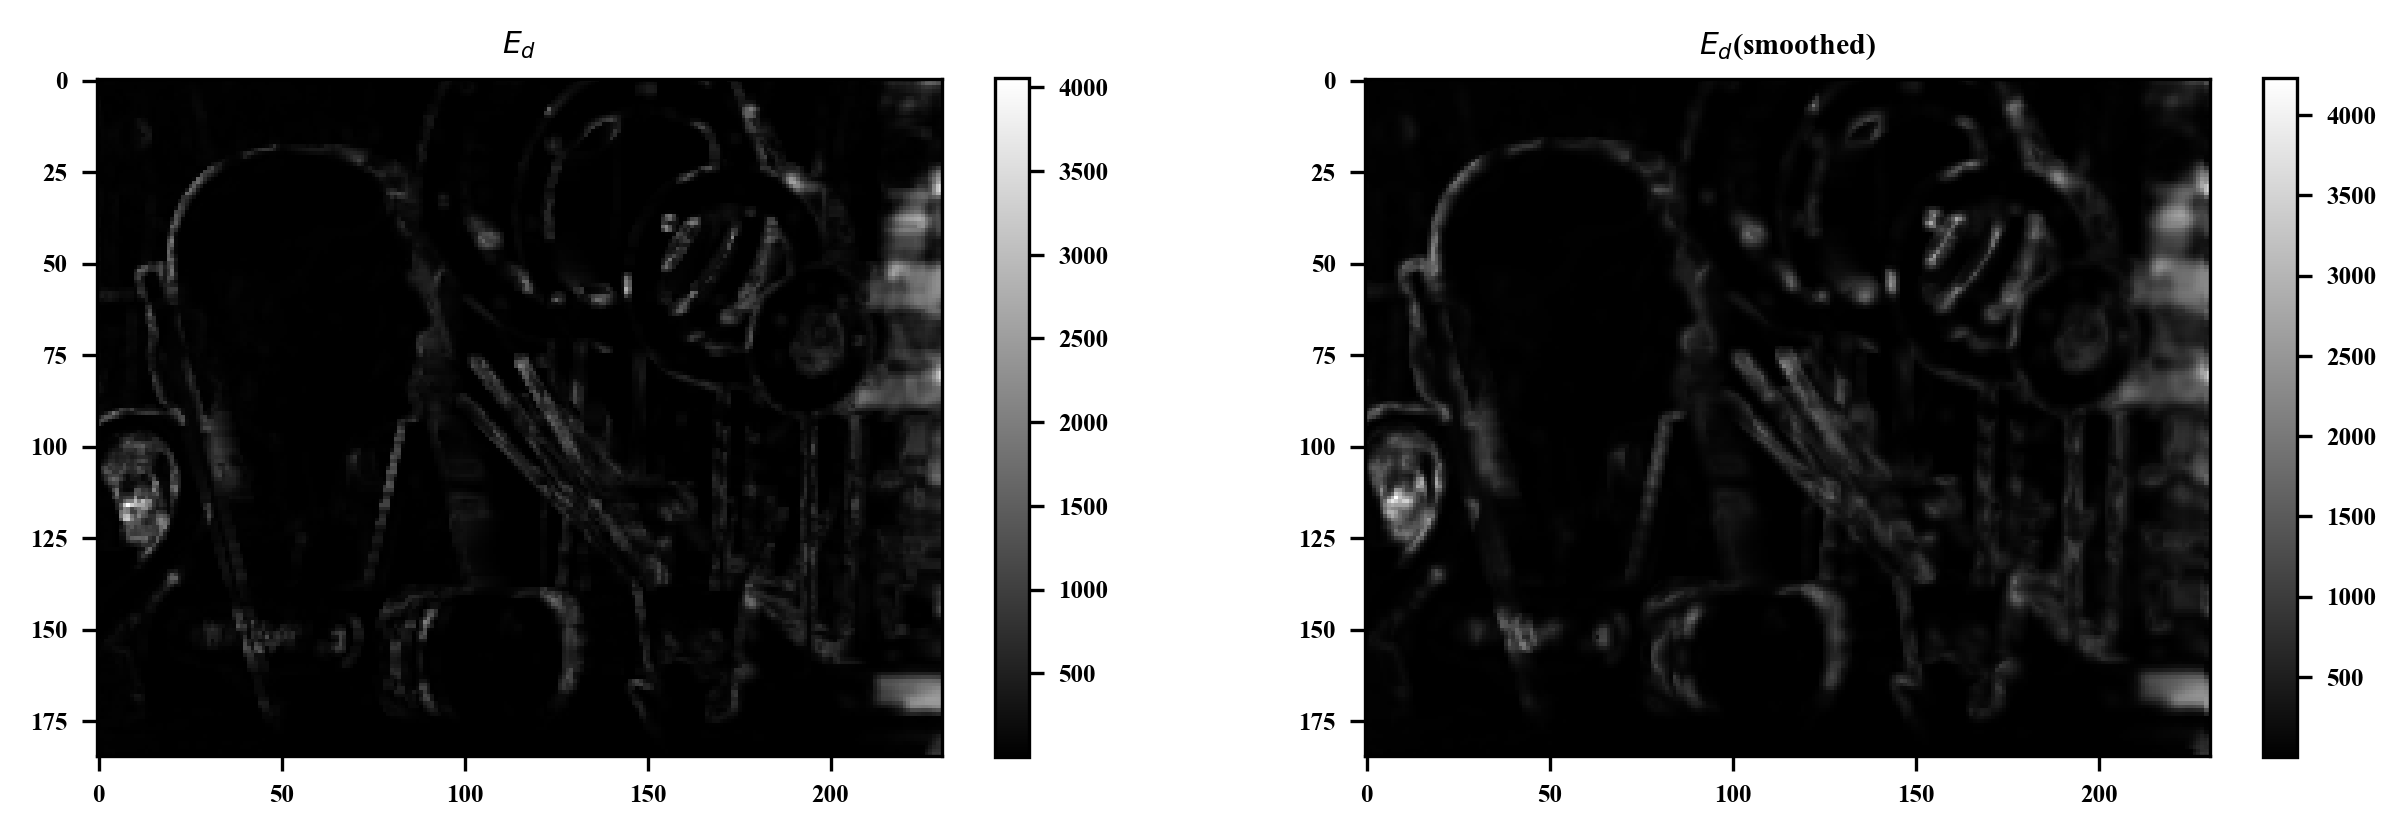

In [24]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(10, 3), dpi=300)
plt.subplot(121)
plt.title('$E_d$')
plt.imshow(E_d, cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.title('$E_d$(smoothed)')
plt.imshow(E_d_smoothed, cmap='gray')
plt.colorbar()
#plt.savefig('./E_d_3x3.jpg', bbox_inches = 'tight')

**Calculate depth.**
$$
Z(i, j) = f \cdot \frac{T}{d(i,j)}
$$

In [26]:
def cal_Z(Z, d, f, T):
    I = Z.shape[0]
    J = Z.shape[1]
    for i in range(I):
        for j in range(J):
            if d[i][j] < 10:
                Z[i][j] = f * T / 10
            else:
                Z[i][j] = f * T / d[i][j]

In [27]:
f = 30
T = 20
Z = np.zeros((image_shape[0], image_shape[1]))
Z_smoothed = np.zeros((image_shape[0], image_shape[1]))
cal_Z(Z, D, f, T)
cal_Z(Z_smoothed, D_smoothed, f, T)

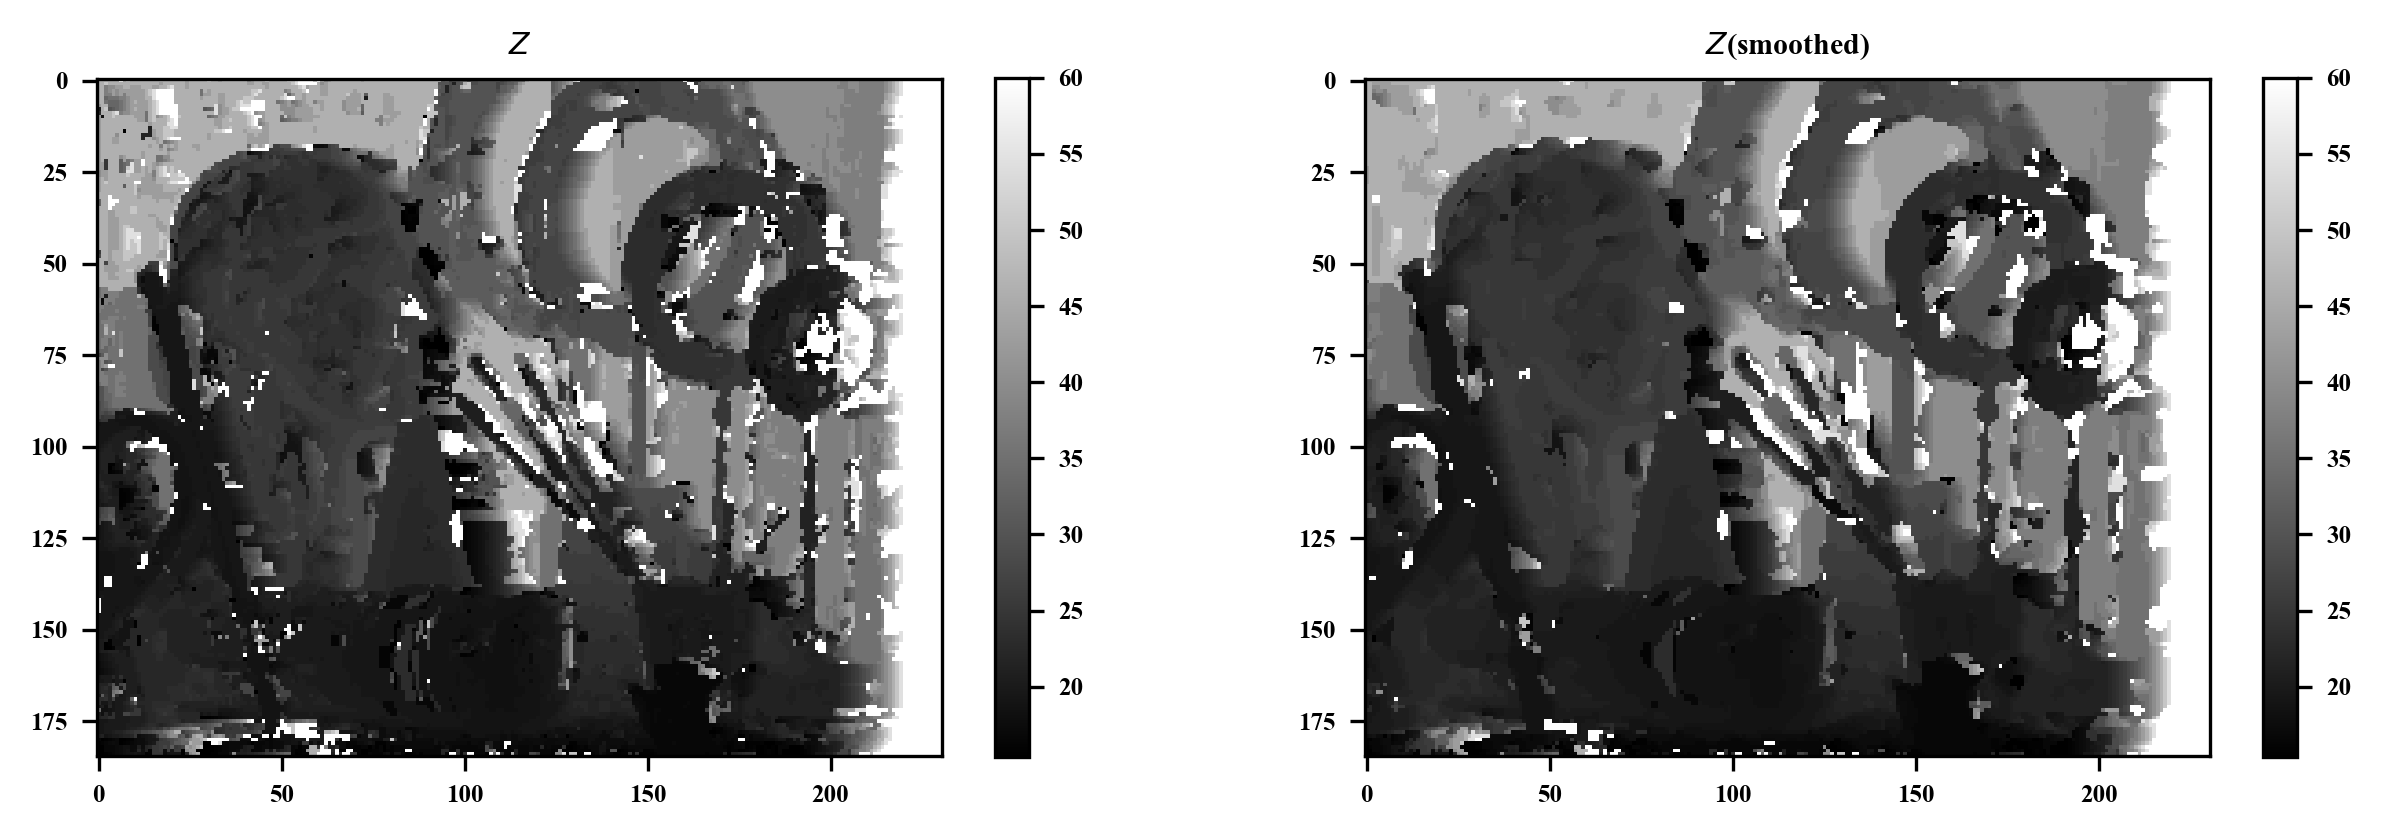

In [28]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(10, 3), dpi=300)
plt.subplot(121)
plt.title('$Z$')
plt.imshow(Z, cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.title('$Z$(smoothed)')
plt.imshow(Z_smoothed, cmap='gray')
plt.colorbar()
plt.savefig('./Z_3x3.jpg', bbox_inches = 'tight')

In [29]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

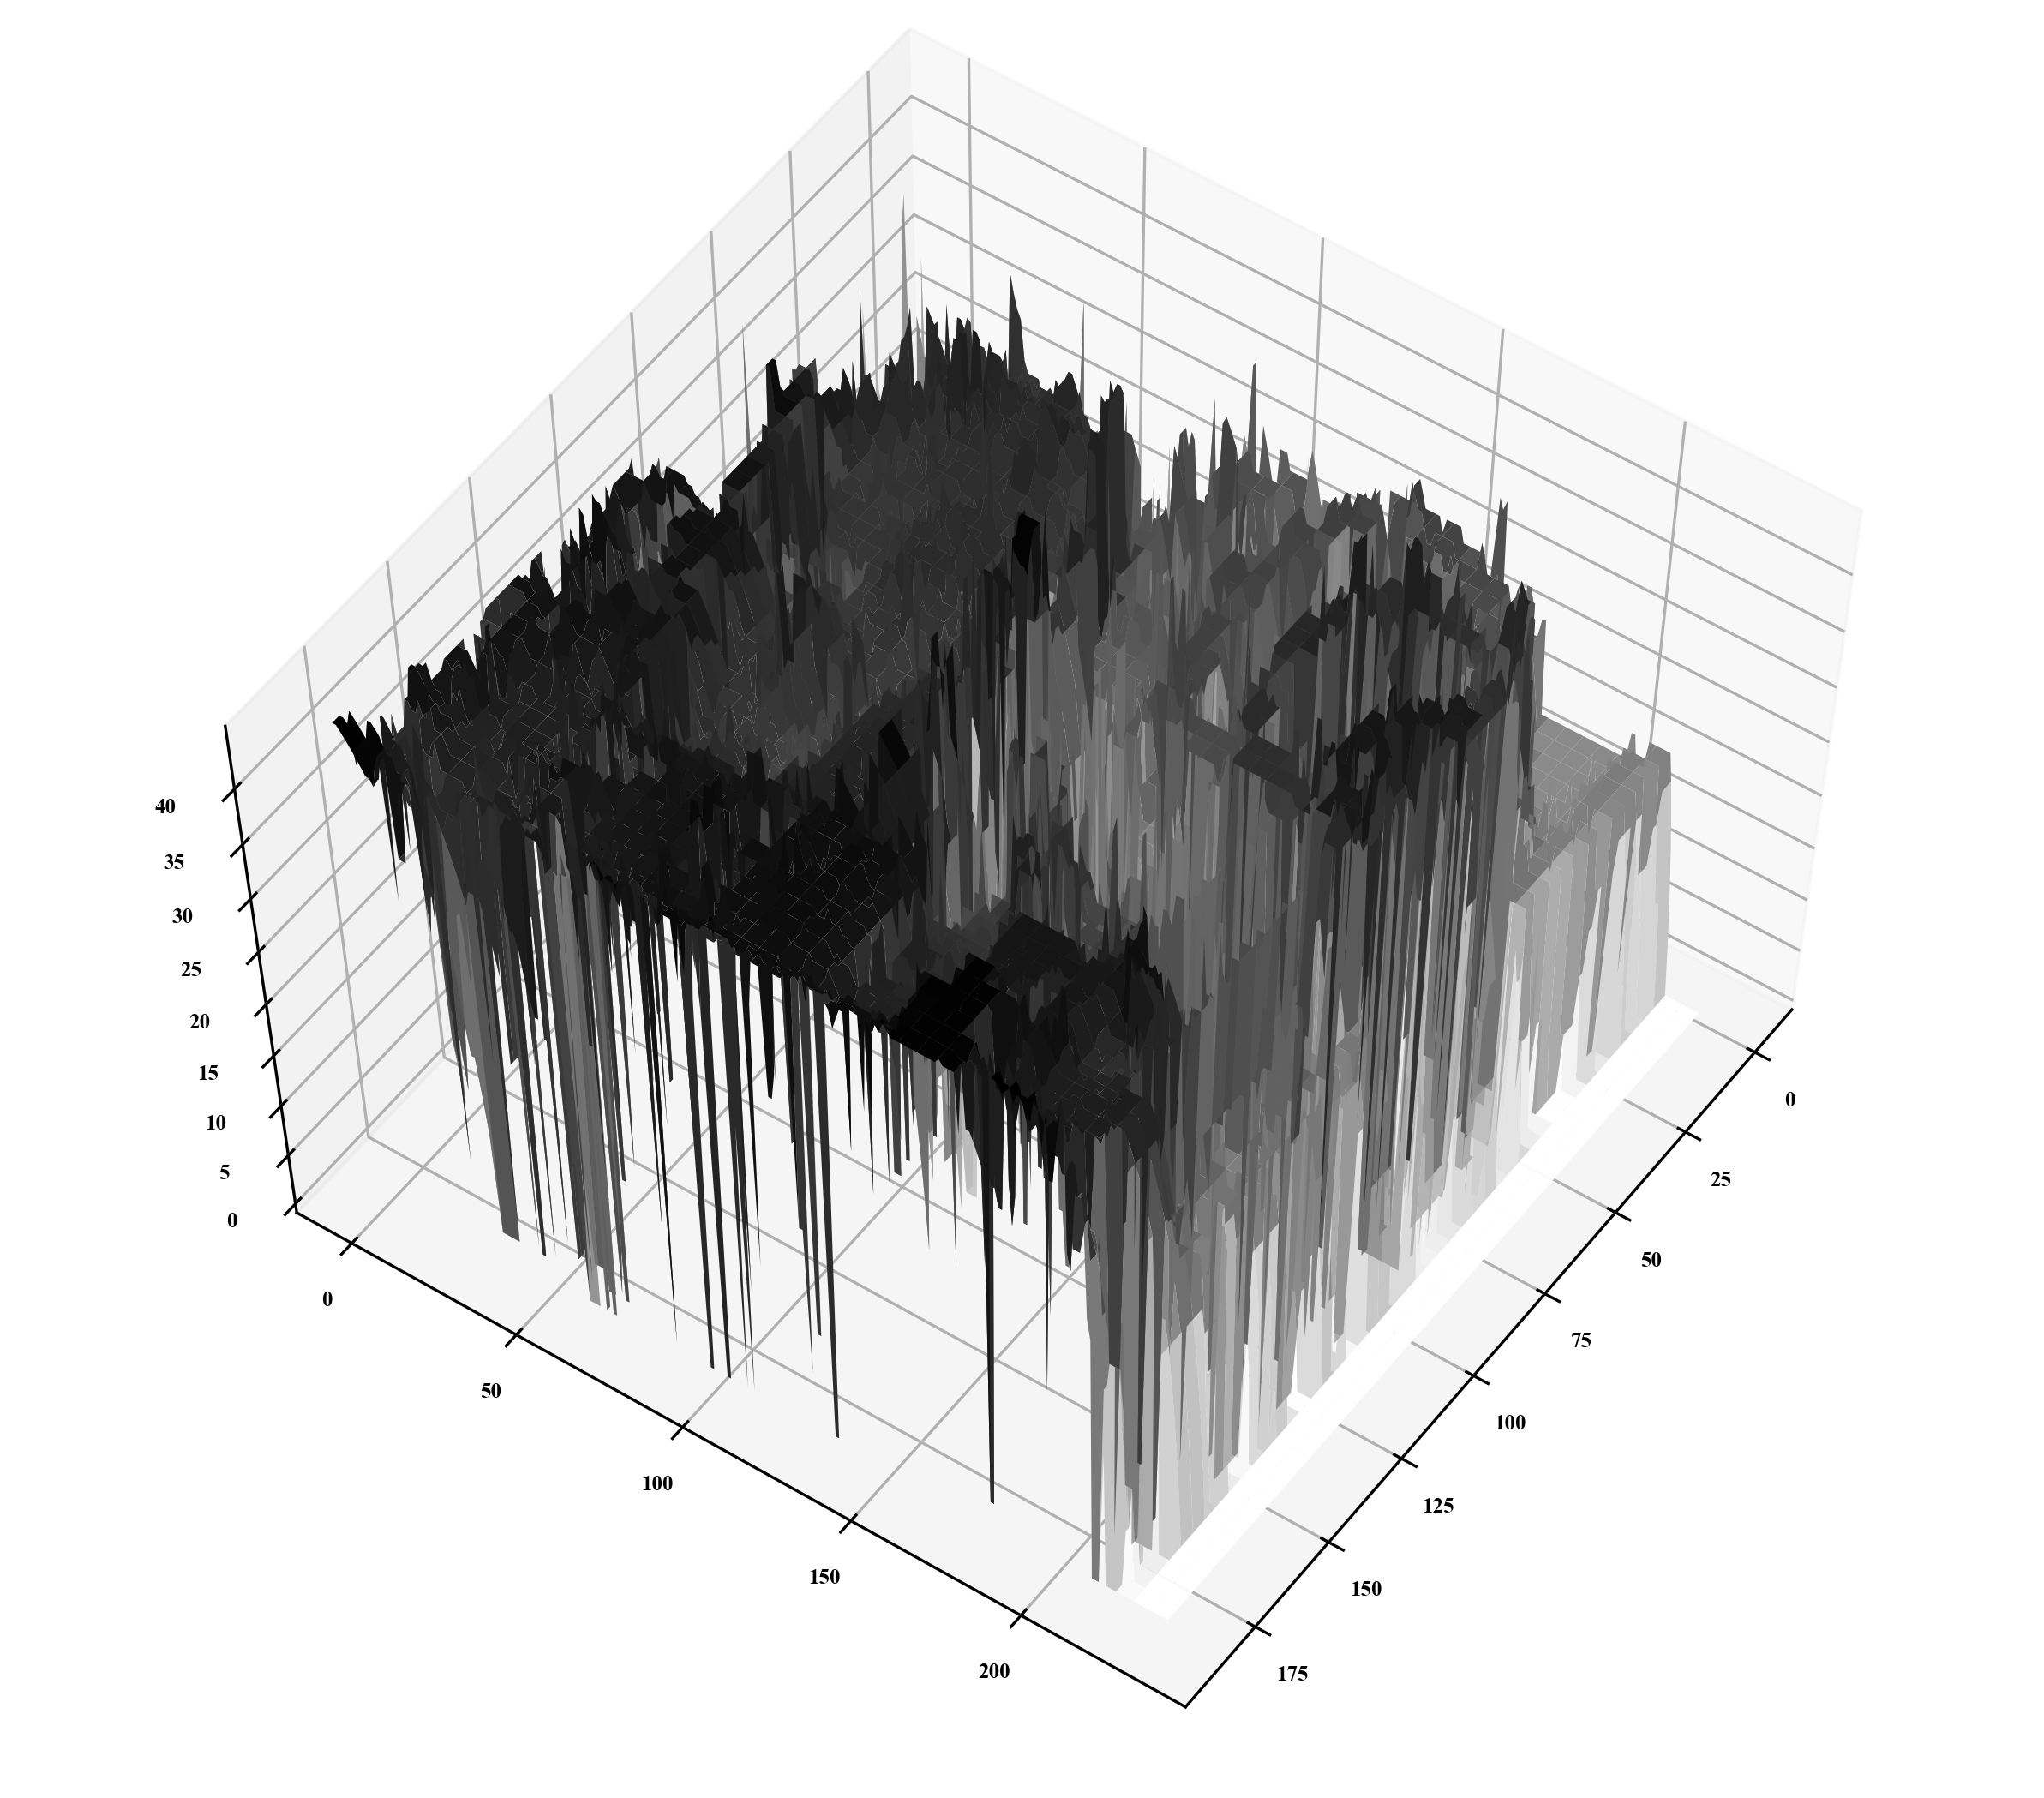

In [30]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(10, 9), dpi=300)
x = np.linspace(0, image_shape[0], image_shape[0])
y = np.linspace(0, image_shape[1], image_shape[1])
x, y = np.meshgrid(x, y)
z = Z.max() - Z
ax = plt.subplot(projection='3d')
ax.plot_surface(x, y, z.T, cmap='binary')
ax.view_init(elev=60,azim=35)
#plt.savefig('./depth_3D_3x3.jpg', bbox_inches = 'tight')

## Line Growing Based Stereo Matching

$$
e(i, j, d) = \frac{1}{3 \cdot n \cdot m} \sum_{x=i}^{i+n} \sum_{y=j}^{j+m} \sum_{k=1}^3 (L(x, y+d, k) - R(x, y, k))^2
$$

In [31]:
def cal_energy_at_pixel(L, R, i, j, d, n, m):
    energy = 0
    for x in range(i, i + n):
        for y in range(j, j + m):
            for k in range(3):
                energy += (L[x][(int)(y + d)][k] - R[x][y][k]) ** 2
    energy = energy / (3 * n * m)
    return energy

In [32]:
def find_min_disparity(L, R, i, j, n, m, max_d):
    min_d = 0
    min_energy = cal_energy_at_pixel(L, R, i, j, 0, n, m)
    for d_index in range(max_d):
        energy = cal_energy_at_pixel(L, R, i, j, d_index, n, m)
        if min_energy > energy:
            min_d = d_index
            min_energy = energy
    return min_d

In [33]:
def find_next_root(L, R, D, n, m, max_d):
    I = D.shape[0]
    J = D.shape[1]
    for i in range(I):
        for j in range(J):
            if D[i][j] < 0:
                d = find_min_disparity(L, R, i, j, n, m, max_d)
                D[i][j] = d
                return i, j, d
    return -1, -1, -1

In [34]:
def regin_growing(L, R, D, i, j, root_d, n, m, threshold):
    I = D.shape[0]
    J = D.shape[1]
    
    if i > 0 and D[i - 1][j] < 0:
        energy_up = cal_energy_at_pixel(L, R, i - 1, j, root_d, n, m)
        if energy_up < threshold:
            D[i - 1][j] = root_d
            regin_growing(L, R, D, i - 1, j, root_d, n, m, threshold)
            
    if i < I - 1 and D[i + 1][j] < 0:
        energy_down = cal_energy_at_pixel(L, R, i + 1, j, root_d, n, m)
        if energy_down < threshold:
            D[i + 1][j] = root_d
            regin_growing(L, R, D, i + 1, j, root_d, n, m, threshold)
            
    if j > 0 and D[i][j - 1] < 0:
        energy_left = cal_energy_at_pixel(L, R, i, j - 1, root_d, n, m)
        if energy_left < threshold:
            D[i][j - 1] = root_d
            regin_growing(L, R, D, i, j - 1, root_d, n, m, threshold)
            
    if j < J - 1 and D[i][j + 1] < 0:
        energy_right = cal_energy_at_pixel(L, R, i, j + 1, root_d, n, m)
        if energy_right < threshold:
            D[i][j + 1] = root_d
            regin_growing(L, R, D, i, j + 1, root_d, n, m, threshold)

In [35]:
def cal_D_regin_growing_based(L, R, D, n, m, max_d, threshold):
    L = np.pad(L, ((0, n - 1),(0, m - 1 + max_d), (0, 0)), 'edge')
    R = np.pad(R, ((0, n - 1),(0, m - 1 + max_d), (0, 0)), 'edge')
    
    while True:
        root_i, root_j, root_d = find_next_root(L, R, D, n, m, max_d)
        if root_i < 0:
            return
        regin_growing(L, R, D, root_i, root_j, root_d, n, m, threshold)

In [36]:
D_regin_growing_based = np.full((image_shape[0], image_shape[1]), -1)
cal_D_regin_growing_based(L, R, D_regin_growing_based, 3, 3, 40, 100)

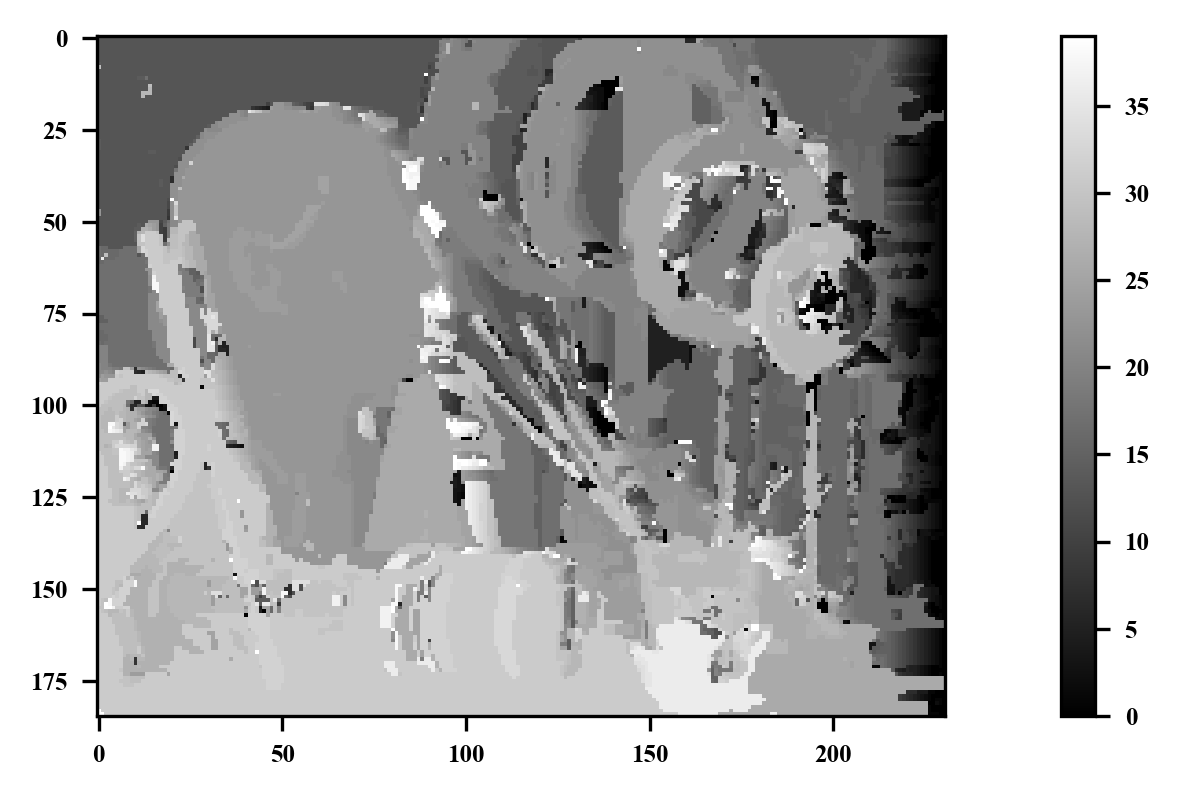

In [37]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(10, 3), dpi=300)
plt.imshow(D_regin_growing_based, cmap='gray')
plt.colorbar()
#plt.savefig('./D_regin_growing_3x3.jpg', bbox_inches = 'tight')

In [38]:
f = 30
T = 20
Z_regin_growing_based = np.zeros((image_shape[0], image_shape[1]))
cal_Z(Z_regin_growing_based, D_regin_growing_based, f, T)

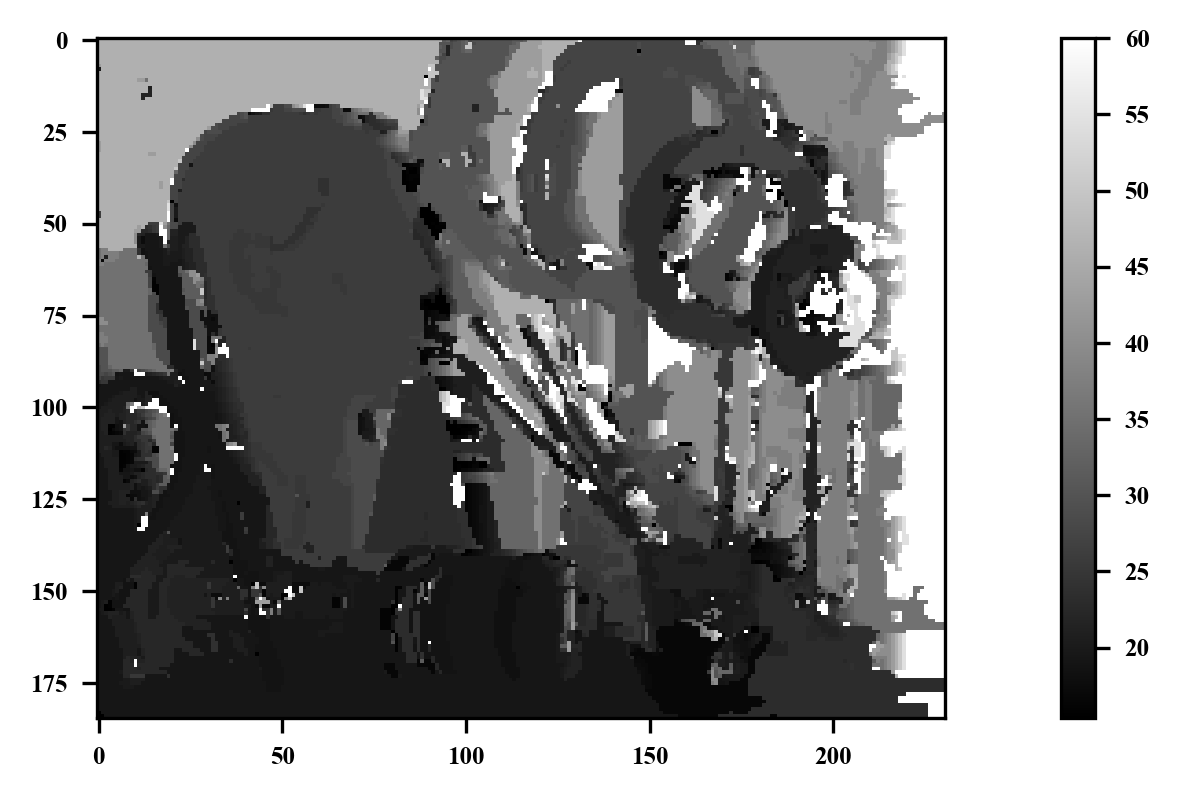

In [39]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(10, 3), dpi=300)
plt.imshow(Z_regin_growing_based, cmap='gray')
plt.colorbar()
#plt.savefig('./Z_regin_growing_3x3.jpg', bbox_inches = 'tight')

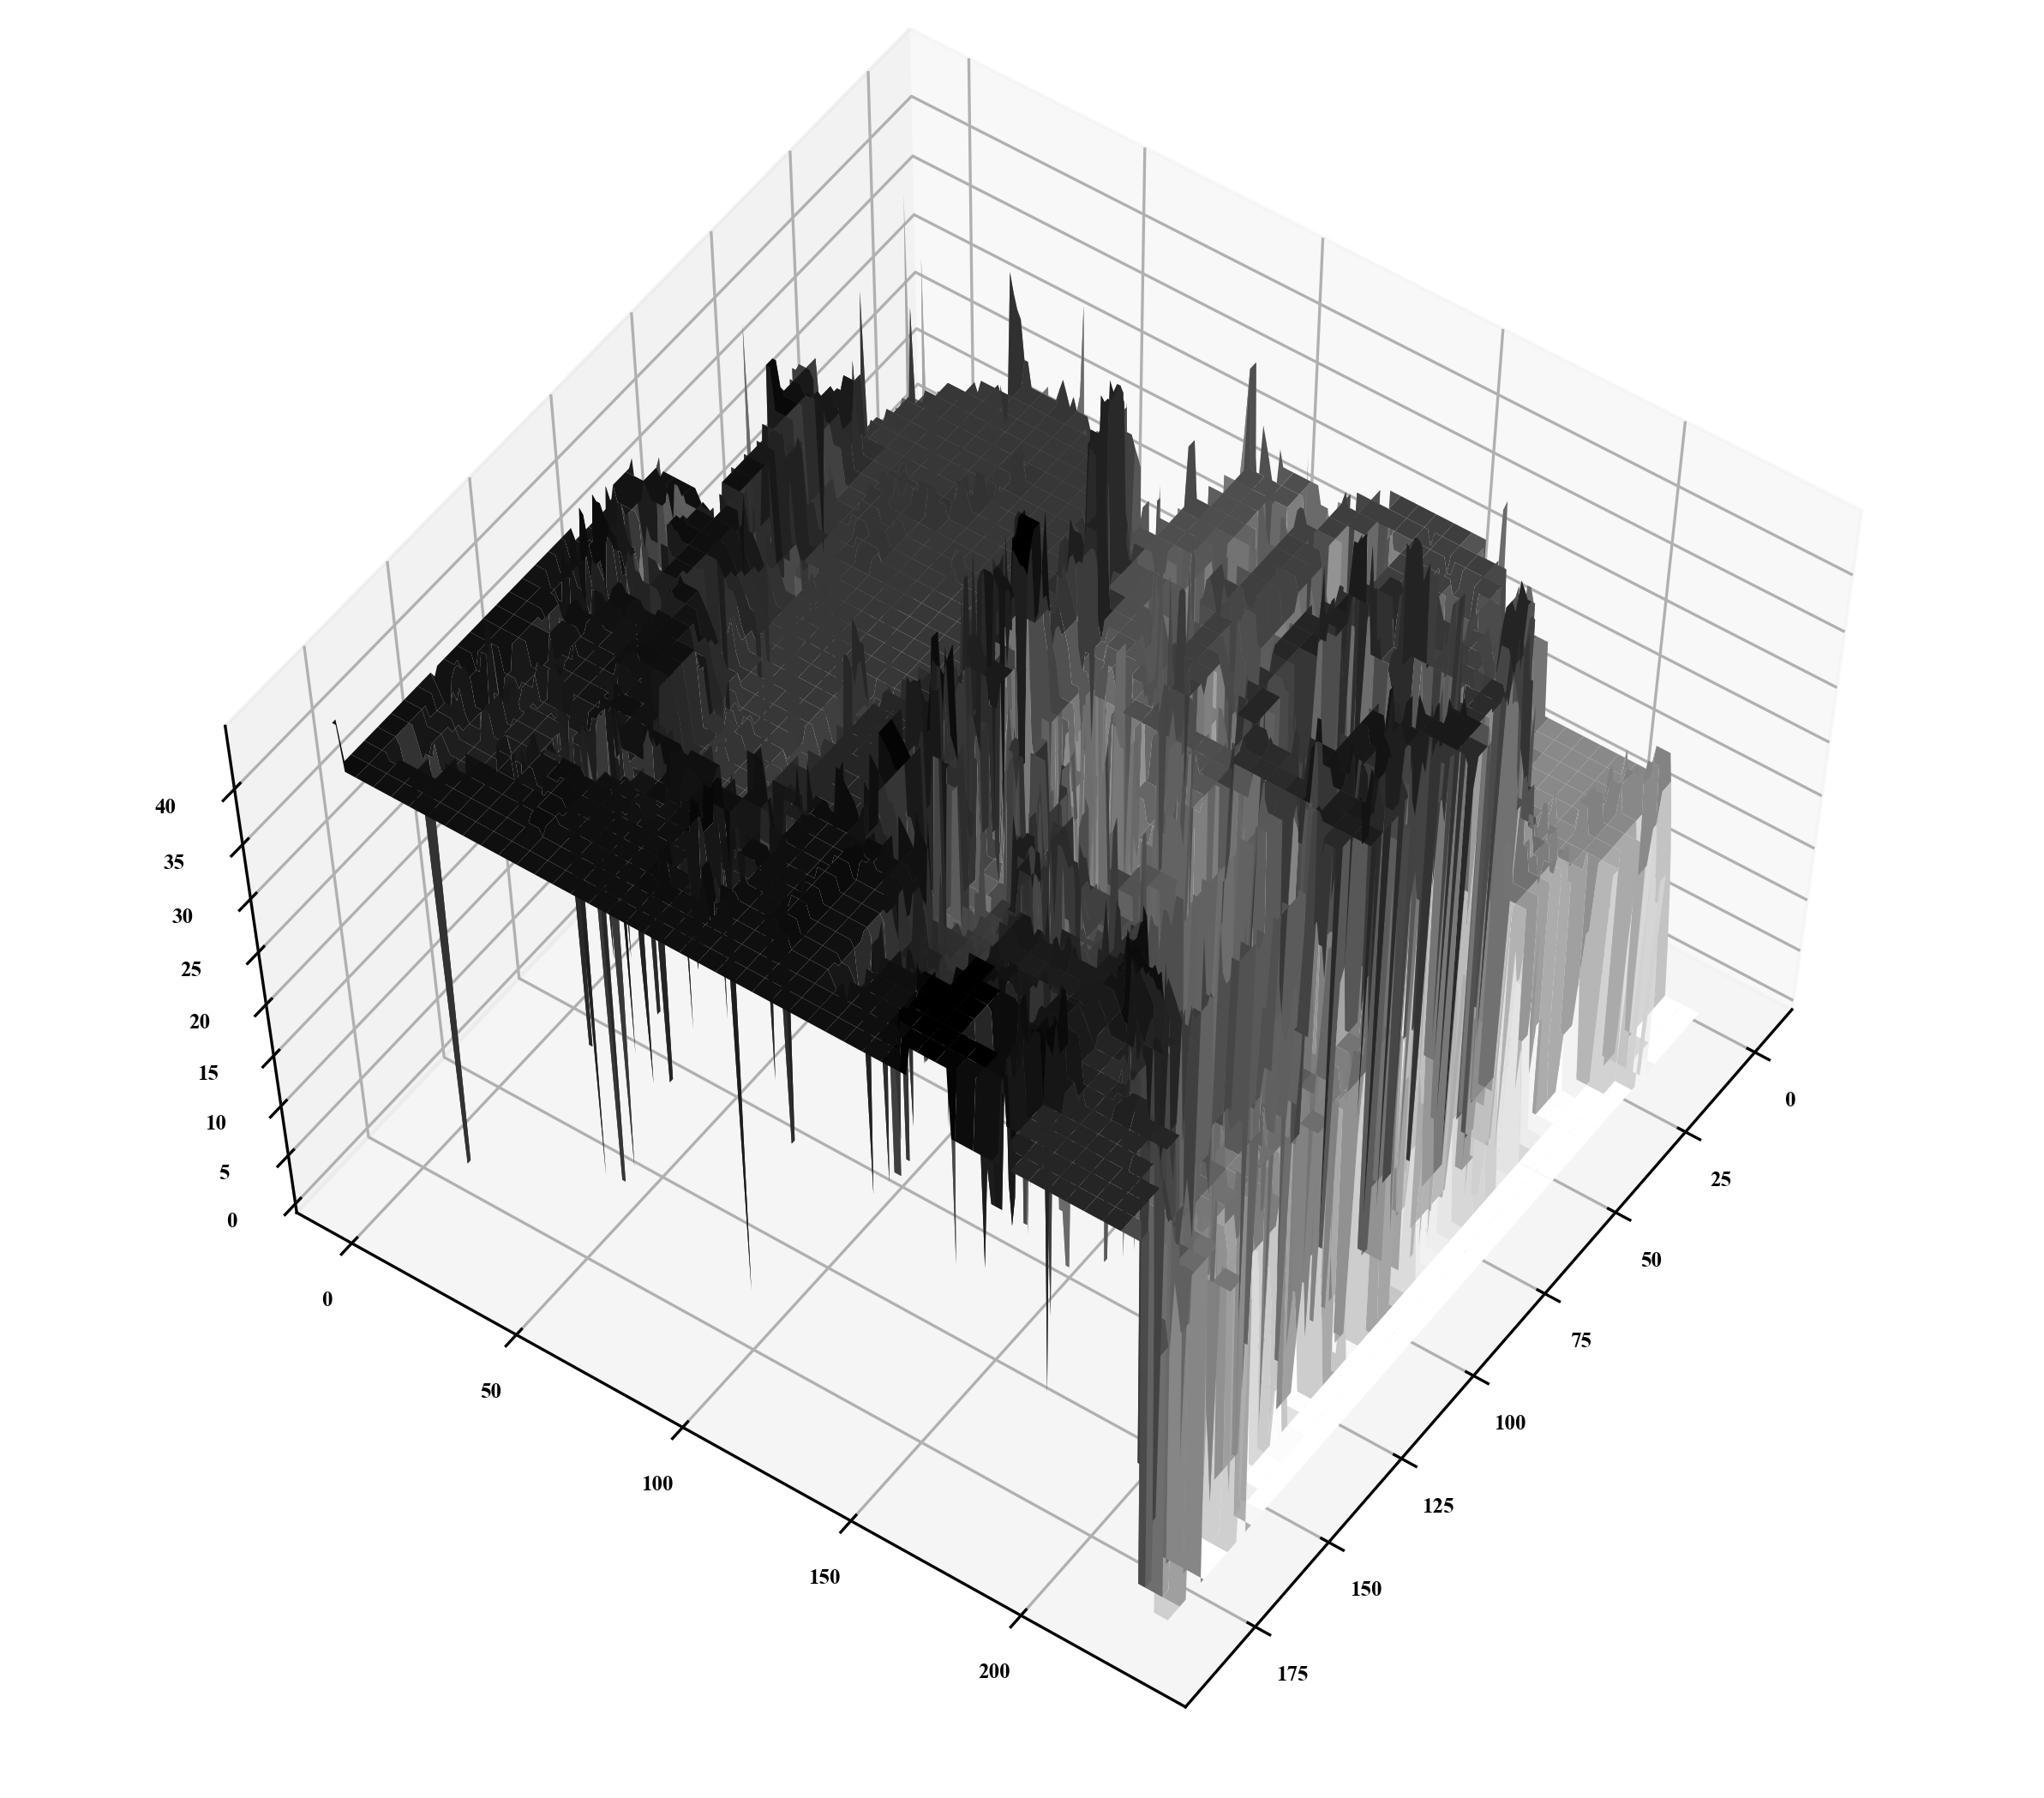

In [40]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(10, 9), dpi=300)
x = np.linspace(0, image_shape[0], image_shape[0])
y = np.linspace(0, image_shape[1], image_shape[1])
x, y = np.meshgrid(x, y)
z = Z_regin_growing_based.max() - Z_regin_growing_based
ax = plt.subplot(projection='3d')
ax.plot_surface(x, y, z.T, cmap='binary')
ax.view_init(elev=60,azim=35)
#plt.savefig('./depth_regin_growing_3D_3x3.jpg', bbox_inches = 'tight')

In [276]:
energy_list = []
i = 80
j = 110
d_list = np.linspace(-30, 30, 61)
for d_index in d_list:
    energy_list.append(cal_energy_at_pixel(L, R, i, j, d_index, 1, 3))

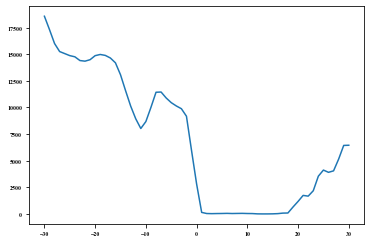

In [277]:
plt.plot(d_list, energy_list)

In [287]:
cal_energy_at_pixel(L, R, i, j, 7, 3, 3)

89.62962962962963